## Lab 2: Classification
Group 2 Team Members:

- Name 1: Aniketh Vankina
- Name 2: Indy Dhillon 
- Name 3: Jason Rupp 
- Name 4: Suchismita Moharana 

## Data Preparation

In [1]:
#Loading Libraries

import datetime
import itertools
import os
import pathlib
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import yellowbrick

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')

/Users/suchismitamoharana/opt/anaconda3/envs/ML7331/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
header_names = [
    'age',
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'wage_per_hour',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'capital_gains',
    'capital_losses',
    'stock_dividends',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'instance_weight', ## this field is not used as a feature
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'num_emp',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'weeks_worked',
    'year',
    'income_50k',
]


data_dir = os.path.join(pathlib.Path(os.getcwd()).parent, 'data')
df = pd.read_csv(os.path.join(data_dir, 'census-income.data.csv'), header=None, names=header_names)
df_test = pd.read_csv(os.path.join(data_dir, 'census-income.test.csv'), header=None, names=header_names)
df = pd.concat([df,df_test]) ## the test file is also labelled so they can be merged
df.drop(columns=['instance_weight']) ## not used for our analysis

categorical_features = [
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'year',
]
df[categorical_features] = df[categorical_features].astype('category')

In [3]:
### Drop columns not used in modelling
df = df.drop(
    columns=[
        'region_prev_res',
        'state_prev_res',
        'det_hh_fam_stat',
        'det_hh_summ',
        'mig_chg_msa',
        'mig_chg_reg',
        'mig_move_reg',
        'mig_same',
        'mig_prev_sunbelt',
        'country_father',
        'country_mother',
        'country_self',
        'year',
    ]
)

In [4]:
# This is section one of the data processing, will be using the same data as shown in the minilab
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299285 entries, 0 to 99761
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   age               299285 non-null  int64   
 1   class_worker      299285 non-null  category
 2   det_ind_code      299285 non-null  category
 3   det_occ_code      299285 non-null  category
 4   education         299285 non-null  category
 5   wage_per_hour     299285 non-null  int64   
 6   hs_college        299285 non-null  category
 7   marital_stat      299285 non-null  category
 8   major_ind_code    299285 non-null  category
 9   major_occ_code    299285 non-null  category
 10  race              299285 non-null  category
 11  hisp_origin       299285 non-null  category
 12  sex               299285 non-null  category
 13  union_member      299285 non-null  category
 14  unemp_reason      299285 non-null  category
 15  full_or_part_emp  299285 non-null  category
 16  cap

### Data Preperation Part 2

In [5]:
# Sampling the dataset
selection_df = df.sample(frac = .001)

In [6]:
selection_df.shape

(299, 29)

In [7]:
def preprocess_pipeline(numeric_features, categorical_features):
    ### Scale numerical, one hot categorical

    numeric_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)]
    )
    preprocess_pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
        ]
    )
    
    return preprocess_pipe

In [8]:
### Preprocess the data
numeric_features = selection_df.select_dtypes(include=['int64', 'float64']).columns
categorical_features_income = selection_df.select_dtypes(include=['object','bool', 'category']).drop(['income_50k'], axis=1).columns
X_selection_income = selection_df.drop('income_50k', axis=1)
y_selection_income = selection_df['income_50k']
preprocessor_income = preprocess_pipeline(numeric_features, categorical_features_income)
X_selection_preprocessed_income = preprocessor_income.fit_transform(X_selection_income)

higer_degrees = [
    ' Bachelors degree(BA AB BS)', 
    ' Masters degree(MA MS MEng MEd MSW MBA)', 
    ' Prof school degree (MD DDS DVM LLB JD)',
    ' Doctorate degree(PhD EdD)',
]
selection_df['graduated'] = 'no'
selection_df.loc[selection_df['education'].isin(higer_degrees), 'graduated'] = 'yes'
selection_df = selection_df.drop(['education'], axis=1)

categorical_features_grad = selection_df.select_dtypes(include=['object','bool', 'category']).drop(['graduated'], axis=1).columns
X_selection_grad = selection_df.drop(columns=['graduated'])
y_selection_grad = selection_df['graduated']
preprocessor_grad = preprocess_pipeline(numeric_features, categorical_features_grad)
X_selection_preprocessed_grad = preprocessor_grad.fit_transform(X_selection_grad)

In [9]:
### Make a list of all the columns after one hot encoding
ohe_income = preprocessor_income['preprocessor'].named_transformers_['cat']['onehot']
cat_processed_income = ohe_income.get_feature_names(X_selection_income[categorical_features_income].columns)
all_processed_cols_income = np.concatenate((numeric_features, cat_processed_income), axis=0)

ohe_grad = preprocessor_grad['preprocessor'].named_transformers_['cat']['onehot']
cat_processed_grad = ohe_grad.get_feature_names(X_selection_grad[categorical_features_grad].columns)
all_processed_cols_grad = np.concatenate((numeric_features, cat_processed_grad), axis=0)

Optimal number of features for Income: 12
Max Score : 0.9598870056497175


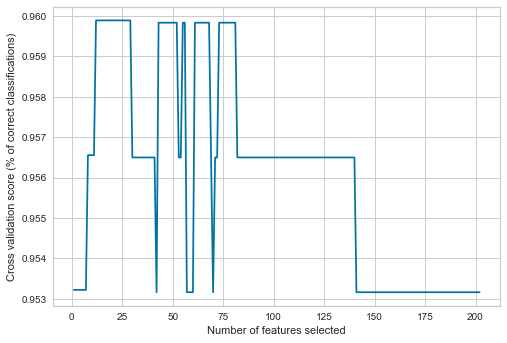

In [10]:


### RFE CV to find best features 
clf = LogisticRegression(n_jobs=-1)
rfecv_income = RFECV(clf, step=1, cv=5)
rfecv_income.fit(X_selection_preprocessed_income, y_selection_income)
print("Optimal number of features for Income: %d" % rfecv_income.n_features_)
print("Max Score :", max(rfecv_income.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_income.grid_scores_) + 1), rfecv_income.grid_scores_)
plt.show()

Optimal number of features for Graduated: 109
Max Score : 0.8728813559322035


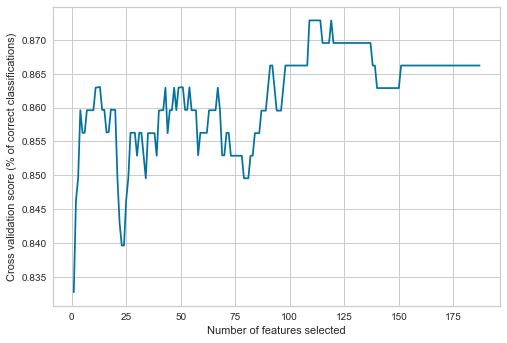

In [11]:
import warnings
warnings.filterwarnings('ignore')

### RFE CV to find best features 
clf = LogisticRegression(n_jobs=-1)
rfecv_grad = RFECV(clf, step=1, cv=5)
rfecv_grad.fit(X_selection_preprocessed_grad, y_selection_grad)
print("Optimal number of features for Graduated: %d" % rfecv_grad.n_features_)
print("Max Score :", max(rfecv_grad.grid_scores_) )



# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_grad.grid_scores_) + 1), rfecv_grad.grid_scores_)
plt.show()

In [12]:
### Show all selected features
selected_features_income = all_processed_cols_income[rfecv_income.support_]
selected_features_grad = all_processed_cols_grad[rfecv_grad.support_]
print(selected_features_income)
print(selected_features_grad)

['capital_gains' 'weeks_worked' 'class_worker_ Private' 'det_occ_code_16'
 'education_ Prof school degree (MD DDS DVM LLB JD)'
 'marital_stat_ Married-civilian spouse present'
 'major_ind_code_ Public administration'
 'major_occ_code_ Executive admin and managerial' 'union_member_ No'
 'full_or_part_emp_ Not in labor force' 'tax_filer_stat_ Single'
 'citizenship_ Native- Born abroad of American Parent(s)']
['age' 'wage_per_hour' 'capital_gains' 'capital_losses' 'stock_dividends'
 'class_worker_ Local government' 'class_worker_ Not in universe'
 'class_worker_ Private' 'det_ind_code_0' 'det_ind_code_1'
 'det_ind_code_2' 'det_ind_code_4' 'det_ind_code_5' 'det_ind_code_9'
 'det_ind_code_11' 'det_ind_code_19' 'det_ind_code_22' 'det_ind_code_30'
 'det_ind_code_32' 'det_ind_code_33' 'det_ind_code_34' 'det_ind_code_41'
 'det_ind_code_42' 'det_ind_code_43' 'det_ind_code_47' 'det_ind_code_49'
 'det_ind_code_50' 'det_occ_code_0' 'det_occ_code_3' 'det_occ_code_8'
 'det_occ_code_10' 'det_occ_code_

In [13]:
### log 
X_selection_log_income = X_selection_income.copy()
X_selection_log_income['wage_per_hour'] = np.log10(X_selection_log_income['wage_per_hour'] + 1)
X_selection_log_income['capital_gains'] = np.log10(X_selection_log_income['capital_gains'] + 1)
X_selection_log_income['capital_losses'] = np.log10(X_selection_log_income['capital_losses'] + 1)
X_selection_log_income['stock_dividends'] = np.log10(X_selection_log_income['stock_dividends'] + 1)
X_selection_log_preprocessed_income = preprocessor_income.fit_transform(X_selection_log_income)

X_selection_log_grad = X_selection_grad.copy()
X_selection_log_grad['wage_per_hour'] = np.log10(X_selection_log_grad['wage_per_hour'] + 1)
X_selection_log_grad['capital_gains'] = np.log10(X_selection_log_grad['capital_gains'] + 1)
X_selection_log_grad['capital_losses'] = np.log10(X_selection_log_grad['capital_losses'] + 1)
X_selection_log_grad['stock_dividends'] = np.log10(X_selection_log_grad['stock_dividends'] + 1)
X_selection_log_preprocessed_grad = preprocessor_grad.fit_transform(X_selection_log_grad)


Optimal number of features for Income: 9
Max Score : 0.9598870056497175


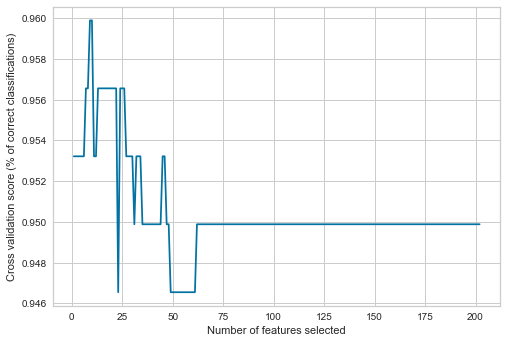

In [14]:
clf = LogisticRegression(n_jobs=-1)
rfecv_log_income = RFECV(clf, step=1, cv=5)
rfecv_log_income.fit(X_selection_log_preprocessed_income, y_selection_income)
print("Optimal number of features for Income: %d" % rfecv_log_income.n_features_)
print("Max Score :", max(rfecv_log_income.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_log_income.grid_scores_) + 1), rfecv_log_income.grid_scores_)
plt.show()

Optimal number of features for Graduated: 112
Max Score : 0.8762146892655368


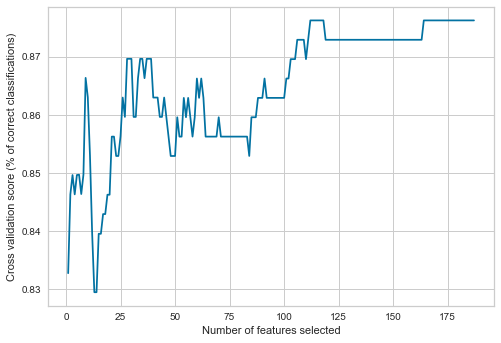

In [15]:
clf = LogisticRegression(n_jobs=-1)
rfecv_log_grad = RFECV(clf, step=1, cv=5)
rfecv_log_grad.fit(X_selection_log_preprocessed_grad, y_selection_grad)
print("Optimal number of features for Graduated: %d" % rfecv_log_grad.n_features_)
print("Max Score :", max(rfecv_log_grad.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_log_grad.grid_scores_) + 1), rfecv_log_grad.grid_scores_)
plt.show()

In [16]:
### Show all selected features
#index columns of sparse matrix
X_selected_income = X_selection_preprocessed_income.tocsr()[:,rfecv_income.support_] 
X_selected_grad = X_selection_preprocessed_grad.tocsr()[:,rfecv_grad.support_] 

selected_features_income = all_processed_cols_income[rfecv_income.support_]
selected_features_grad = all_processed_cols_grad[rfecv_grad.support_]

print(selected_features_income)
print(selected_features_grad)

['capital_gains' 'weeks_worked' 'class_worker_ Private' 'det_occ_code_16'
 'education_ Prof school degree (MD DDS DVM LLB JD)'
 'marital_stat_ Married-civilian spouse present'
 'major_ind_code_ Public administration'
 'major_occ_code_ Executive admin and managerial' 'union_member_ No'
 'full_or_part_emp_ Not in labor force' 'tax_filer_stat_ Single'
 'citizenship_ Native- Born abroad of American Parent(s)']
['age' 'wage_per_hour' 'capital_gains' 'capital_losses' 'stock_dividends'
 'class_worker_ Local government' 'class_worker_ Not in universe'
 'class_worker_ Private' 'det_ind_code_0' 'det_ind_code_1'
 'det_ind_code_2' 'det_ind_code_4' 'det_ind_code_5' 'det_ind_code_9'
 'det_ind_code_11' 'det_ind_code_19' 'det_ind_code_22' 'det_ind_code_30'
 'det_ind_code_32' 'det_ind_code_33' 'det_ind_code_34' 'det_ind_code_41'
 'det_ind_code_42' 'det_ind_code_43' 'det_ind_code_47' 'det_ind_code_49'
 'det_ind_code_50' 'det_occ_code_0' 'det_occ_code_3' 'det_occ_code_8'
 'det_occ_code_10' 'det_occ_code_

## Modeling and Evaluation

In [17]:
#### Decision Tree for income
classifier = DecisionTreeClassifier()
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : [2, None],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1,2,3],
    
}

CV_dt_income = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_dt_income.fit(X_selected_income, y_selection_income)
    
print('Best Score: {s}'.format(s=CV_dt_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_dt_income.best_params_))  

Best Score: 0.9632183908045977
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}


In [18]:
#### Decision Tree for graduation
classifier = DecisionTreeClassifier()
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : [2, None],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1,2,3],
    
}

CV_dt_grad = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_dt_grad.fit(X_selected_grad, y_selection_grad)
    
print('Best Score: {s}'.format(s=CV_dt_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_dt_grad.best_params_))  

Best Score: 0.8729885057471265
Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [19]:
#Feature importance graph
#imp = dt_clf.feature_importances_

#Plt
#plt.bar(range(len(imp)),imp)

In [20]:
#### Logistic Regression for income
classifier = LogisticRegression()
param_grid = { 
    'class_weight': ['balanced', None],
    #'penalty' : ['l1', 'l2',],
    'solver' : ['lbfgs', 'liblinear'],
    'max_iter': [99999],
}

CV_lr_income = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_lr_income.fit(X_selected_income, y_selection_income)
    
print('Best Score: {s}'.format(s=CV_lr_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_lr_income.best_params_)) 


Best Score: 0.9665517241379309
Best Parameters: {'class_weight': None, 'max_iter': 99999, 'solver': 'lbfgs'}


In [21]:
#### Logistic Regression for graduation
classifier = LogisticRegression()
param_grid = { 
    'class_weight': ['balanced', None],
    #'penalty' : ['l1', 'l2',],
    'solver' : ['lbfgs', 'liblinear'],
    'max_iter': [99999],
}

CV_lr_grad = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_lr_grad.fit(X_selected_grad, y_selection_grad)
    
print('Best Score: {s}'.format(s=CV_lr_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_lr_grad.best_params_)) 

Best Score: 0.8964367816091954
Best Parameters: {'class_weight': None, 'max_iter': 99999, 'solver': 'lbfgs'}


In [22]:
#### KNN for income
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [5, 10,100,200],
}
CV_knn_income = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_knn_income.fit(X_selected_income, y_selection_income)

print('Best Score: {s}'.format(s=CV_knn_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_knn_income.best_params_))


Best Score: 0.9632183908045976
Best Parameters: {'n_neighbors': 5}


In [23]:
#### KNN for graduation
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [5, 10,100,200],
}
CV_knn_grad = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_knn_grad.fit(X_selected_grad, y_selection_grad)

print('Best Score: {s}'.format(s=CV_knn_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_knn_grad.best_params_))

Best Score: 0.8495402298850576
Best Parameters: {'n_neighbors': 10}


In [24]:
#### AdaBoost for income
import warnings
warnings.filterwarnings('ignore')
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
param_grid = { 
    'n_estimators': [50, 100, 200],
    'learning_rate': [.1, .5, 1],
    'algorithm': ['SAMME.R', 'SAMME']
}

CV_ada_income = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_ada_income.fit(X_selected_income, y_selection_income)

print('Best Score: {s}'.format(s=CV_ada_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_ada_income.best_params_))

Best Score: 0.9632183908045976
Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 200}


In [25]:
#### AdaBoost for graduation
import warnings
warnings.filterwarnings('ignore')
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
param_grid = { 
    'n_estimators': [50, 100, 200],
    'learning_rate': [.1, .5, 1],
    'algorithm': ['SAMME.R', 'SAMME']
}

CV_ada_grad = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_ada_grad.fit(X_selected_grad, y_selection_grad)

print('Best Score: {s}'.format(s=CV_ada_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_ada_grad.best_params_))


Best Score: 0.8831034482758622
Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 100}


In [26]:
#### Gradient Boosting for income
from sklearn.ensemble import GradientBoostingClassifier

param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'learning_rate' : [0.001, 0.1, 0.5, 1],
    'max_depth': [1,2,3],
}

classifier = GradientBoostingClassifier(random_state=1)


CV_gbc_income = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_gbc_income.fit(X_selected_income, y_selection_income)

print('Best Score: {s}'.format(s=CV_gbc_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_gbc_income.best_params_))

Best Score: 0.9632183908045976
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10}


In [27]:
#### Gradient Boosting for graduation
from sklearn.ensemble import GradientBoostingClassifier

param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'learning_rate' : [0.001, 0.1, 0.5, 1],
    'max_depth': [1,2,3],
}

classifier = GradientBoostingClassifier(random_state=1)


CV_gbc_grad = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs= -1)
CV_gbc_grad.fit(X_selected_grad, y_selection_grad)

print('Best Score: {s}'.format(s=CV_gbc_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_gbc_grad.best_params_))

Best Score: 0.8696551724137931
Best Parameters: {'learning_rate': 1, 'max_depth': 1, 'n_estimators': 50}


### Model and Evaluation 1

### Model and Evaluation 2

### Model and Evaluation 3

### Model and Evaluation 4

In [28]:
import yellowbrick 
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ROCAUC
#%matplotlib inline


def plot_rocauc_chart(model_name, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10,6))
    plt.title("ROC Curve and AUC", fontsize=18)
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)
    visualizer = ROCAUC(model_name, classes=["Not-churned", "Churned"])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    plt.legend()
    plt.show()
    
    
def plot_confusionmatrix(model_name, X_train, y_train, X_test, y_test):
    confusion_matrix(model_name, X_train, y_train, X_test, y_test,classes=[0,1])
    plt.tight_layout()
    plt.show()

In [ ]:
#from sklearn.metrics import accuracy_score
#
#y_pred = CV_lr_grad.predict(X_grad_train)
#y_test_pred = CV_lr_grad.predict(X_grad_test)
#train_acc = accuracy_score(y_pred, y_grad_train)
#test_acc = accuracy_score(y_test_pred, y_grad_test)
#print(f'Train accuracy is {train_acc}. Test accuracy is {test_acc}')

In [30]:
X_grad_train, X_grad_test, y_grad_train, y_grad_test = train_test_split(X_selected_grad, y_selection_grad, test_size=0.2)

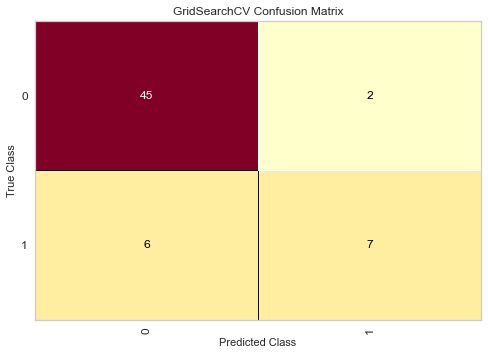

<Figure size 576x396 with 0 Axes>

In [31]:
#Decision Tree confusion matrix for Graduate classification
plot_confusionmatrix(CV_dt_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

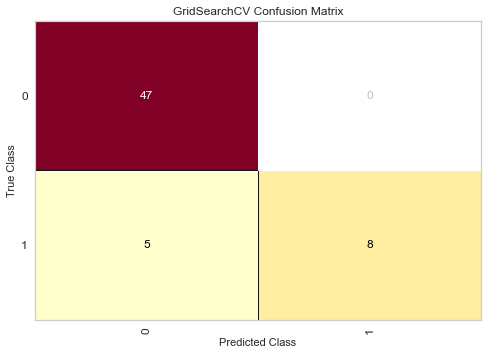

<Figure size 576x396 with 0 Axes>

In [32]:
#Logistics Regression confusion matrix for Graduate classification
plot_confusionmatrix(CV_lr_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

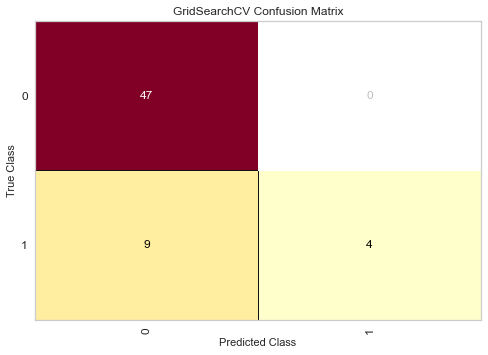

<Figure size 576x396 with 0 Axes>

In [33]:
#KNN confusion matrix for Graduate classification
plot_confusionmatrix(CV_knn_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

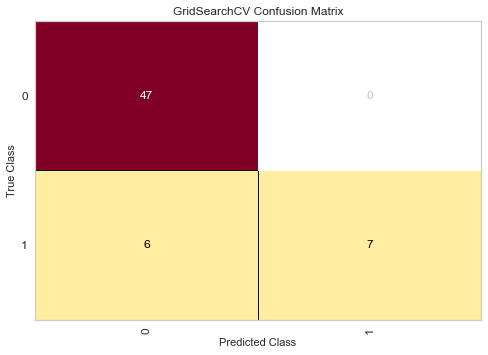

<Figure size 576x396 with 0 Axes>

In [34]:
#Ada boost confusion matrix for Graduate classification
plot_confusionmatrix(CV_ada_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

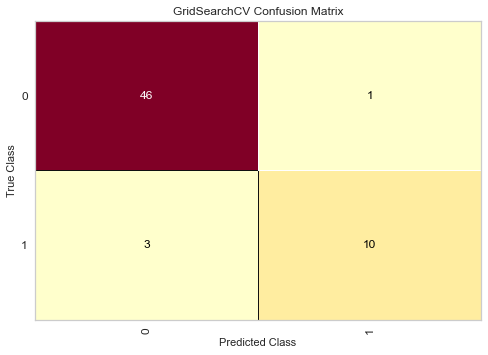

<Figure size 576x396 with 0 Axes>

In [35]:
#Gradient boost confusion matrix for Graduate classification
plot_confusionmatrix(CV_gbc_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

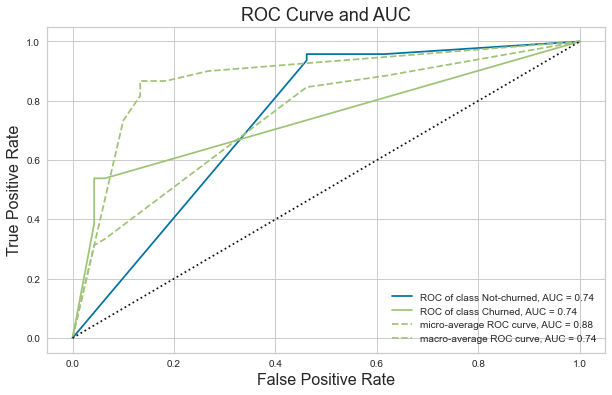

In [36]:
#Decision Tree ROC cureve and AUC for Graduate classification

plot_rocauc_chart(CV_dt_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

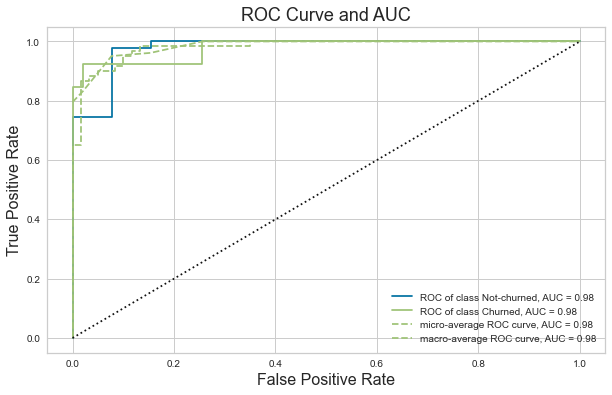

In [37]:
#Logistics regression ROC cureve and AUC for Graduate classification

plot_rocauc_chart(CV_lr_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

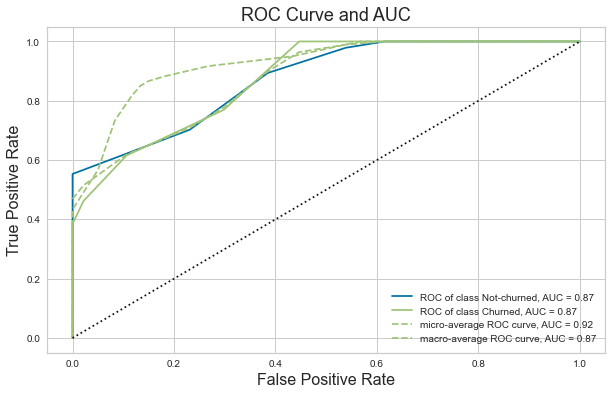

In [38]:
#KNN ROC cureve and AUC for Graduate classification

plot_rocauc_chart(CV_knn_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)


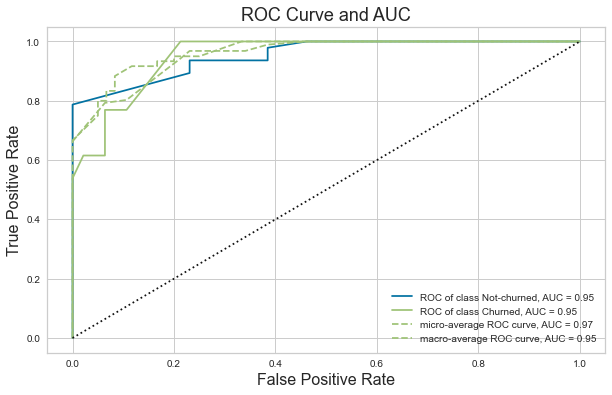

In [39]:
#Ada Boost ROC cureve and AUC for Graduate classification

plot_rocauc_chart(CV_ada_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

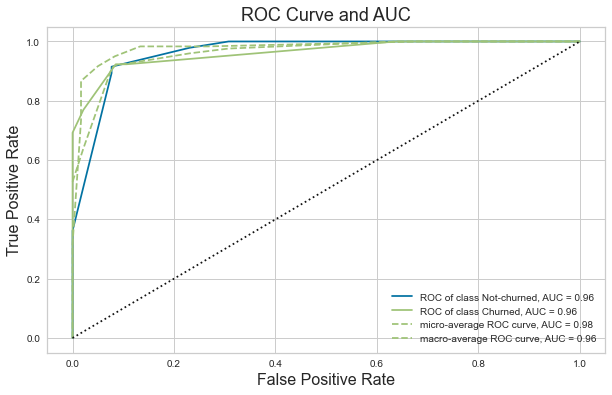

In [40]:
#Gradient Boost ROC cureve and AUC for Graduate classification

plot_rocauc_chart(CV_gbc_grad, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

### Model and Evaluation 5

### Model and Evaluation 6

### Deployment

### Exceptional Work